In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, randint
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [24]:
df = pd.read_csv('Breast_cancer_data.csv')
print(df.head())
print(df.shape)

   mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   diagnosis  
0          0  
1          0  
2          0  
3          0  
4          0  
(569, 6)


In [25]:
class SAHyperOpt:
    def __init__(self,features,target,data,params,model,initTemp,iterations,coolingFactor,iterationsPerTemperature):
        self.X = df[features]
        self.y = df[target]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.3)
        self.model=model
        self.params=params
        self.nextParams={}
        self.currParams={}
        self.currAcc=0
        self.nextAcc=0
        self.initialTemp=initTemp
        self.temperature=initTemp
        self.iterations=iterations
        self.coolingFactor=coolingFactor
        self.iterPerTemp=iterationsPerTemperature
        self.accArr=[]
        self.tempArr=[]
        self.probabilityArr=[]
        self.docArr=[] 
        self.startParams={}
        self.bestParams={'accuracy':0}
        
    def createParams(self):
        myParams={}
        for i in self.params:
            decider=np.random.uniform(0,1)
            paramValue=i[1]+(decider*(i[2]-i[1]))
            if type(i[1])==float:
                paramValue=round(paramValue, 2)
            elif type(i[1])==int:
                paramValue=int(paramValue)
            self.currParams[i[0]]=paramValue
        #print("self.currParams",self.currParams)
    
    def changeParamsV1(self,n=1):
        sign=np.random.choice([-1,1])
        for i in self.params:
            currValue=self.currParams[i[0]]
            decider=np.random.uniform(0,n)
            paramValue=(sign*decider*(i[2]-i[1]))+currValue
            if type(i[1])==float:
                paramValue=min(max(round(paramValue, 2),i[1]),i[2])
            elif type(i[1])==int:
                paramValue=min(max(int(paramValue),i[1]),i[2])
            self.nextParams[i[0]]=paramValue
        #print("self.nextParams",self.nextParams)
    
    def changeParamsV2(self,n=1):
        sign=np.random.choice([-1,1])
        pc=randint(0,len(self.params)-1)
        currValue=self.currParams[self.params[pc][0]]
        decider=np.random.uniform(0,n)
        paramValue=(sign*decider*(self.params[pc][2]-self.params[pc][1]))+currValue
        if type(self.params[pc][1])==float:
            paramValue=min(max(round(paramValue, 2),self.params[pc][1]),self.params[pc][2])
        elif type(self.params[pc][1])==int:
            paramValue=min(max(int(paramValue),self.params[pc][1]),self.params[pc][2])
        self.nextParams=self.currParams.copy()
        self.nextParams[self.params[pc][0]]=paramValue
        
    def changeParamsV3(self,n=1):
        pc=randint(0,len(self.params)-1)
        decider=np.random.uniform(0,1)
        paramValue=self.params[pc][1]+(decider*(self.params[pc][2]-self.params[pc][1]))
        if type(self.params[pc][1])==float:
            paramValue=round(paramValue, 2)
        elif type(self.params[pc][1])==int:
            paramValue=int(paramValue)
        self.nextParams=self.currParams.copy()
        self.nextParams[self.params[pc][0]]=paramValue
    
    def createModel(self,mode):
        if mode==0:
            self.model.set_params(**self.currParams)
            self.model.fit(self.X_train, self.y_train)
            self.y_pred=self.model.predict(self.X_test)
            self.currAcc=accuracy_score(self.y_pred, self.y_test)
        elif mode==1:
            self.model.set_params(**self.nextParams)
            self.model.fit(self.X_train, self.y_train)
            self.y_pred=self.model.predict(self.X_test)
            self.nextAcc=accuracy_score(self.y_pred, self.y_test)
        
    def SAOptimizer(self):
        currIterations=1
        sameTempIterations = 0
        self.createParams()
        self.createModel(0)
        self.startParams=self.currParams.copy()
        self.startParams['accuracy']=self.currAcc
        self.changeParamsV3()
        while currIterations<self.iterations:
            print("Iteration ",currIterations)
            self.createModel(1)
            self.tempArr.append(self.temperature)
            self.accArr.append(self.currAcc)
            diff=abs(self.currAcc-self.nextAcc)
            if self.currAcc<self.nextAcc:
                self.currParams=self.nextParams.copy()
                self.createModel(0)
                if sameTempIterations>=self.iterPerTemp:
                    self.temperature=self.coolingFactor*self.temperature
                    sameTempIterations=0
            else:
                decider=np.random.uniform(0,1)
                probability=math.e**(-(diff*self.initialTemp)/self.temperature)
                self.probabilityArr.append(probability)
                if decider < probability:
                    self.currParams=self.nextParams.copy()
                    self.createModel(0)
                    if sameTempIterations>=self.iterPerTemp:
                        self.temperature=self.coolingFactor*self.temperature
                        sameTempIterations=0

            degreeOfChange=1-((self.initialTemp-self.temperature)/self.initialTemp)
            self.docArr.append(degreeOfChange)
                
            self.changeParamsV3(degreeOfChange)
            
            if self.bestParams['accuracy']<self.currAcc:
                self.bestParams=self.currParams.copy()
                self.bestParams['accuracy']=self.currAcc
                        
            currIterations+=1
            sameTempIterations+=1
        
        self.plot(self.accArr,"Accuracy")
        self.plot(self.tempArr,"Temperature")
        self.plot(self.docArr,"Degree of Change")
        self.plot(self.probabilityArr,"Probability of accepting worse path",True)
        rounds=1
        meansum=0
        avgAccArr=[]
        for i in self.accArr:
            meansum=meansum+i
            if rounds==5:
                avgAccArr.append(meansum/rounds)
                rounds=0
                meansum=0
            rounds=rounds+1
        self.plot(avgAccArr,"Average Accuracy per 5 iterations")
        
    def plot(self,myArr,metric,scatter=False):
        plt.figure(figsize=(10,7))
        plt.ylabel(metric)
        plt.xlabel("Iterations")
        plt.title("Simulated Annealing Results - "+metric)
        if not scatter:
            plt.plot([i for i in range(len(myArr))],myArr,label = metric)
        else:
            plt.scatter([i for i in range(len(myArr))],myArr,label = metric)
        plt.legend()
        plt.show()
        

In [26]:
features=['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']
target=['diagnosis']

params=[["num_leaves",2,500],
    ["max_depth",1,50],
    ["learning_rate",0.01,5],
    ["n_estimators",1,1000],
    ["colsample_bytree",0.01,1]]

myInitTemp,myIterations,myCoolingFactor,myIPT=8000,1000,0.988,2

#               (features,target,data,params,model,initTemp,iterations,coolingFactor,iterationsPerTemperature):
myObj=SAHyperOpt(features,target,df,params,lgb.LGBMClassifier(),myInitTemp,myIterations,myCoolingFactor,myIPT)

Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
Iteration  25
Iteration  26
Iteration  27
Iteration  28
Iteration  29
Iteration  30
Iteration  31
Iteration  32
Iteration  33
Iteration  34
Iteration  35
Iteration  36
Iteration  37
Iteration  38
Iteration  39
Iteration  40
Iteration  41
Iteration  42
Iteration  43
Iteration  44
Iteration  45
Iteration  46
Iteration  47
Iteration  48
Iteration  49
Iteration  50
Iteration  51
Iteration  52
Iteration  53
Iteration  54
Iteration  55
Iteration  56
Iteration  57
Iteration  58
Iteration  59
Iteration  60
Iteration  61
Iteration  62
Iteration  63
Iteration  64
Iteration  65
Iteration  66
Iteration  67
Iteration  68
Iteration  69
Iteration  70
Iteration  71
Iteration  72
I

Iteration  556
Iteration  557
Iteration  558
Iteration  559
Iteration  560
Iteration  561
Iteration  562
Iteration  563
Iteration  564
Iteration  565
Iteration  566
Iteration  567
Iteration  568
Iteration  569
Iteration  570
Iteration  571
Iteration  572
Iteration  573
Iteration  574
Iteration  575
Iteration  576
Iteration  577
Iteration  578
Iteration  579
Iteration  580
Iteration  581
Iteration  582
Iteration  583
Iteration  584
Iteration  585
Iteration  586
Iteration  587
Iteration  588
Iteration  589
Iteration  590
Iteration  591
Iteration  592
Iteration  593
Iteration  594
Iteration  595
Iteration  596
Iteration  597
Iteration  598
Iteration  599
Iteration  600
Iteration  601
Iteration  602
Iteration  603
Iteration  604
Iteration  605
Iteration  606
Iteration  607
Iteration  608
Iteration  609
Iteration  610
Iteration  611
Iteration  612
Iteration  613
Iteration  614
Iteration  615
Iteration  616
Iteration  617
Iteration  618
Iteration  619
Iteration  620
Iteration  621
Iteration 

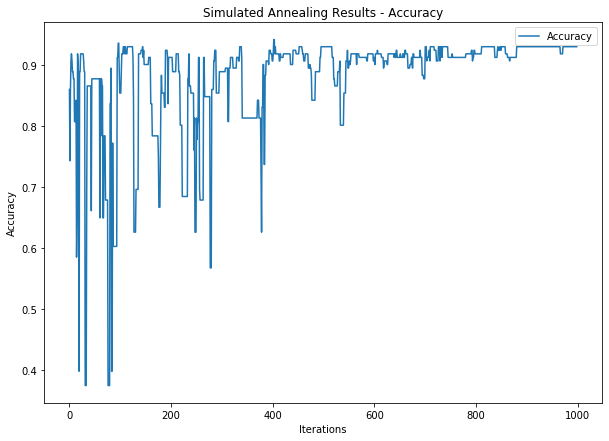

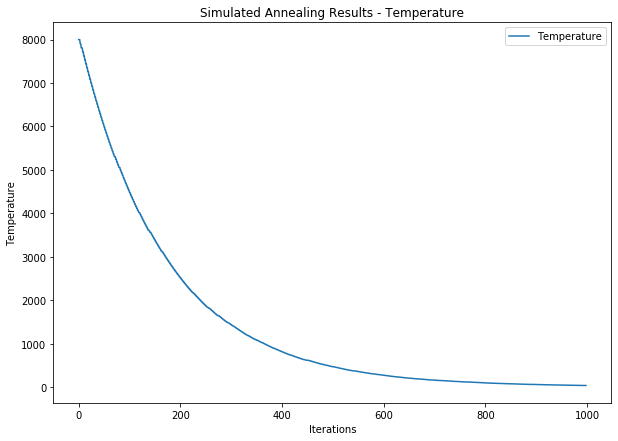

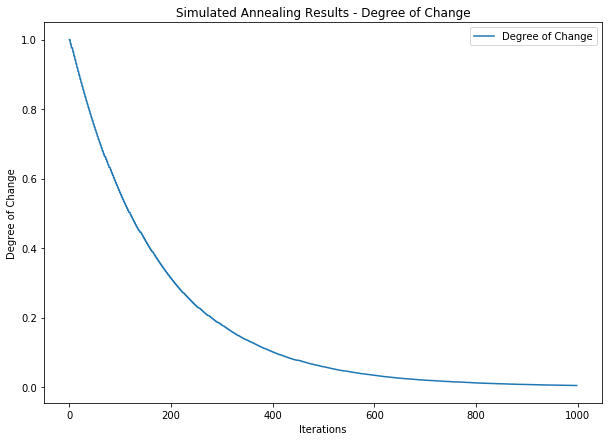

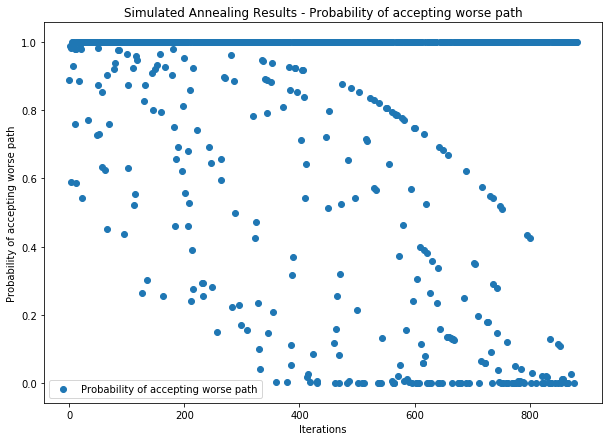

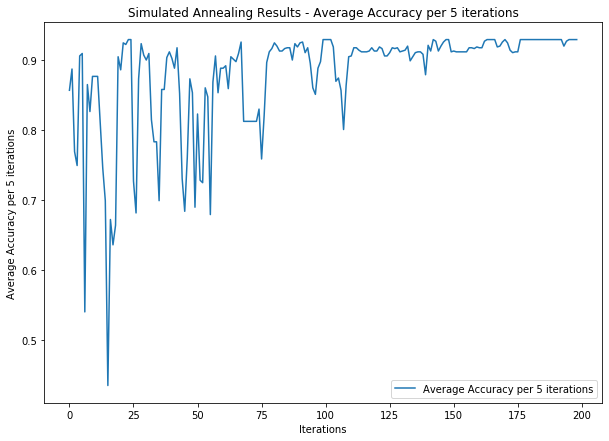

Start Parameters: {'num_leaves': 288, 'max_depth': 25, 'learning_rate': 2.05, 'n_estimators': 422, 'colsample_bytree': 0.67, 'accuracy': 0.8596491228070176}
Best Parameters: {'num_leaves': 273, 'max_depth': 3, 'learning_rate': 1.18, 'n_estimators': 646, 'colsample_bytree': 0.4, 'accuracy': 0.9415204678362573}
Initial Temperature: 8000
Iterations: 1000
Cooling Factor: 0.988
Iterations Per Temperature: 2
Execution Time (sec): 83.71268939971924


In [27]:
startTime = time.time()
myObj.SAOptimizer()
execTime=time.time() - startTime

print("Start Parameters:",myObj.startParams)
print("Best Parameters:",myObj.bestParams)
print("Initial Temperature:",myInitTemp)
print("Iterations:",myIterations)
print("Cooling Factor:",myCoolingFactor)
print("Iterations Per Temperature:",myIPT)
print("Execution Time (sec):",execTime)

In [28]:
print(myObj.bestParams)

{'num_leaves': 273, 'max_depth': 3, 'learning_rate': 1.18, 'n_estimators': 646, 'colsample_bytree': 0.4, 'accuracy': 0.9415204678362573}


In [29]:
print(myObj.startParams)

{'num_leaves': 288, 'max_depth': 25, 'learning_rate': 2.05, 'n_estimators': 422, 'colsample_bytree': 0.67, 'accuracy': 0.8596491228070176}
